In [1]:
import os,sys
import numpy as np
import sympy as sym
import sys
sym.init_printing()
sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *
import pickle
from pathlib import Path

reference= 'ec_reactions'

In [2]:
def get_reaction(lib=''):
    pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
    sys.path.append(os.path.join(os.path.pardir, 'database', 'install', lib, 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
    tcgdb = __import__('py_'+lib)
    func = getattr(tcgdb,lib) 
    rxn = func() # <-- this should work!
    return rxn

def get_pickle_path(rxnObj): 
    return Path('output', rxnObj.name() + '.pickle')

def load_grid(reactionObject):
    filename = get_pickle_path(reactionObject)
    with open(filename, 'rb') as pfile:
        bdfgrid = pickle.load(pfile)
    return bdfgrid

def save_grid(bdfgrid, reactionObject):
    filename = get_pickle_path(reactionObject)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, 'wb+') as pfile:
        pickle.dump(bdfgrid, pfile)

def solve_reaction_grid(reactionObject, mi0=None, Cik0=None, T_range=None, p_range=None, filename=None, reload=False, save=False, odeClass=ScipyPDReactiveODE,Da=None):
    if reload:
        return load_grid(reactionObject)

    i0 = 2 # doesn't matter as long as you pass cik0
    end = 1e5 # end time

    bdfgrid = PDReactiveGrid()

    bdfgrid.solve(reactionObject, ScipyPDReactiveODE, i0, ['T', 'p'], T_range, p_range, end, Cik0=Cik0, mi0=mi0)

    if save:
        save_grid(bdfgrid, reactionObject)

    return bdfgrid

def plot_reaction_grid(rxn, bdfgrid, plot_phases=True,figure_background=None, figure_xlim=[273.15,1273.15], figure_ylim=[0.0,5.0]):
    import matplotlib.pyplot as plt

    def decorate(pdrgd):
        def new_setup_axes(self,axi):
            if(figure_background is not None):
                img = plt.imread(figure_background)
                ip = axi.imshow(img)
            axi.axis('off')
            ax = axi.inset_axes([0.001,0.006,0.995,0.991])
            ax.patch.set_alpha(0.0)
            
            ax.set_xlabel("Temperature (K)")
            ax.set_ylabel("Pressure (GPa)")
            ax.set_xlim(figure_xlim)
            ax.set_ylim(figure_ylim)
            return ax
    
        #replace the display with newdisplay
        pdrgd.setup_axes = new_setup_axes
    
        #return the modified student 
        return pdrgd

    bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid) 
    s=bdfdiag.plot_rho()
    s.set_clim([25., 35.])
    s.set_cmap('jet')

    if plot_phases:
        bdfdiag.plot_phases()
    return bdfdiag

def run_reaction(rxnName=None, mi0=None, Cik0=None, t_range=None, p_range=None, reload=False, save=False,t0=900,p0=2.0,**kwargs):

    rxn = get_reaction(rxnName)

    # initial temperature, pressure and phase volume fraction
    Ti = t0 # kelvin
    pi = GPa2Bar(p0) # bars

    try:
        ode = ScipyPDReactiveODE(rxn)
        end_t = 1000.0
        ode.solve(Ti,pi,mi0,Cik0,end_t,**kwargs)
        display(ode.stime)
        display(ode.final_phases(1.e-2))
        ode.plot()
    except:
        pass

    grid = solve_reaction_grid(rxn, mi0=mi0, Cik0=Cik0, T_range=t_range, p_range=p_range, reload=reload, save=save,**kwargs)
    plot_reaction_grid(rxn,grid, plot_phases=True)
    return rxn, grid

In [3]:
X_Mg_garnet = 9.888
X_Ca_garnet = 10.549
X_Fe_garnet = 16.369
X_tot_garnet = X_Mg_garnet+X_Ca_garnet+X_Fe_garnet

X_py = X_Mg_garnet/X_tot_garnet
X_alm = X_Fe_garnet/X_tot_garnet
X_gr = X_Ca_garnet/X_tot_garnet

print(X_py, X_alm, X_gr)

X_Na_cpx = 6.326

X_Mg_cpx = 9.451
N_Mg_cpx = 0.498

X_Ca_cpx = 14.948
N_Ca_cpx = 0.566

X_Fe_cpx = 2.304
N_Fe_cpx = 0.068

X_Al_cpx = 10.407

X_tot_cpx = X_Na_cpx + X_Mg_cpx + X_Ca_cpx + X_Fe_cpx + X_Al_cpx

N_Ca_di = N_Mg_cpx
X_Ca_di = (N_Ca_di / N_Ca_cpx) * X_Ca_cpx
X_Ca_he = X_Ca_cpx - X_Ca_di

X_di = (X_Mg_cpx + X_Ca_di) / X_tot_cpx
X_jd = (X_Na_cpx + X_Al_cpx) / X_tot_cpx
X_he = 1 - X_di - X_jd

print(X_di, X_jd, X_he)

0.26865185024180843 0.44473727109710376 0.28661087866108786
0.5203777329514817 0.38523344691039685 0.09438882013812144


In [4]:
# Simple eclogite using TCG's Stixrude database

Tmin = 273
Tmax = 1273
nT = 100

Pmin = 0.5
Pmax = 5.0
nP = 100

T = np.linspace(Tmin, Tmax, nT)
P = np.linspace(Pmin, Pmax, nP)

phases = [
    'Clinopyroxene',
    'Orthopyroxene',
    'Quartz',
    'Feldspar', 
    'Garnet', 
    'Kyanite',
]

ems = [
    'Diopside', 'Hedenbergite', 'Clinoenstatite', 'CaTschermaks', 'Jadeite',
    'Enstatite', 'Ferrosilite', 'MgTschermaks', 'OrthoDiopside',
    'Quartz',
    'Anorthite','Albite',
    'Pyrope', 'Almandine', 'Grossular', 'MgMajorite', 'NaMajorite',
    'Kyanite'
]

# mass fractions of the phases

# initialize with eclogitic compositions
# 40% cpx, 33% garnet
# Mg# should be around 50

## Eclogite facies
mi0_eclogite = np.asarray([
    0.40, # cpx
    0.00, # opx
    0.20, # quartz
    0.00, # feldspar
    0.33, # garnet
    0.07 # kyanite
])

# mass fractions of the end-members
# note: * = thermodynamic endmember, set to zero
Cik0 = np.asarray([
    0.25, 0.25, 0., 0., 0.5, # di, hed, *cEn, *cats, jd
    0.5, 0.5, 0., 0., # en, fs, *mats, *oDi
    1., # quartz
    0.25, 0.75, # an, ab
    0.4, 0.4, 0.2, 0., 0., # py, alm, gr, *mgmaj, *namaj
    1., # ky
])

#rxn = get_reaction('ec_simple_slb_rx')

#ode = ScipyPDReactiveODE(rxn)
#end_t = 100000.0
#sol = ode.solve(900,GPa2Bar(0.25),mi0,Cik0,end_t)
#display(ode.stime)
#display(ode.final_phases(0.))
#phasenames = np.array([ode.rxn.phases()[i].name() for i in range(ode.I)], dtype=str)
#phaseabbrev = np.array(['Pv' if (abbrev := ode.rxn.phases()[i].abbrev()) == "MgFePv" else abbrev for i in range(ode.I)], dtype=str)
#mi = ode.sol.y[:ode.I,-1]
#phaseindices = mi > 0.
#display(phasenames[phaseindices], phaseabbrev[phaseindices], mi[phaseindices])

# cpx .20
# opx 0.
# qtz .14
# plg .29
# gt .31
# ky .07


## Granulite facies

mi0_granulite = np.asarray([
    0.09, # cpx
    0.24, # opx
    0.08, # quartz
    0.51, # feldspar
    0.0, # garnet
    0.07 # kyanite
])

In [5]:
from matplotlib import pyplot as plt


In [146]:
i0 = 2 # doesn't matter as long as you pass cik0

bdfgrid = PDReactiveGrid()

Trange = [1000.]
Prange = np.linspace(1.0, 2.75, 100)

nsteps = 12

rhogrids = []
porositygrids = []
Dagrids = []
rxn = get_reaction('ec_simple_slb_rx')
infiltration_Ps = np.linspace(2.4,1.4,nsteps)

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

for step in range(nsteps):
    Dagrid = [[None for j in range(len(Trange))] for i in range(len(Prange))]
    porosity = [[None for j in range(len(Trange))] for i in range(len(Prange))]

    p_in = infiltration_Ps[step]
    end = step
    
    for i, p in enumerate(Prange):
        for j, t in enumerate(Trange):
            poro = (1.0 + np.tanh((p - p_in)*10.))/2. # 0 to 1
            Da_val = 0.0001 + 2.*((poro)**10.)
            Dagrid[i][j] = Da_val
            porosity[i][j] = poro

    Dagrids.append(Dagrid)
    Dagrid = np.asarray(Dagrid)
    porositygrids.append(porosity)
    print(step)
    bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['T', 'p'], Trange, Prange, end, Cik0=Cik0, mi0=mi0_granulite, Da=Dagrid)
    bdfdiag = PDReactiveGridDiagnostics(rxn,bdfgrid)
    rhogrids.append(bdfdiag.rhogrid())

end=10
bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['T', 'p'], Trange, Prange, end, Cik0=Cik0, mi0=mi0_granulite, Da=10.)
bdfdiag = PDReactiveGridDiagnostics(rxn,bdfgrid)
rhogrids.append(bdfdiag.rhogrid())


0
1
2
3
4
5
6
7
8
9
10
11


/var/folders/44/lwghh8zd5zj98qpc8cmt5nx803425w/T/ipykernel_46803/54947520.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,2)


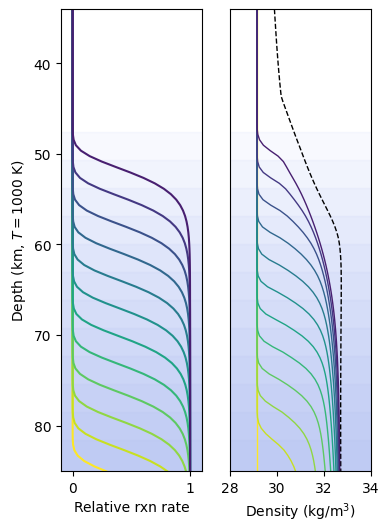

In [168]:
from matplotlib import pyplot as plt
fig = plt.subplots(figsize=(4, 6))

ax1 = plt.subplot(1,2,2)
ax1.set_ylim(1.0/3000/9.8*1e6, 2.5/3000/9.8*1e6)
ax1.set_xlim(28,34)
ax1.invert_yaxis()
ax1.set_xlabel("Density (kg/m$^3$)")

ax2 = plt.subplot(1,2,1)
ax2.set_ylabel("Depth (km, $T=1000$ K)")

ax2.set_ylim(1.0/3000/9.8*1e6, 2.5/3000/9.8*1e6)
ax2.invert_yaxis()
ax2.set_xlim(-0.1, 1.1)
blue = [0.6,0.7,0.9]
ax1.plot(rhogrids[-1], bdfdiag.grid.ygrid/3000/9.8*1e6, 'k--', linewidth=1., alpha=1.)

for i in range(nsteps):
    p1=infiltration_Ps[i]/3000/9.8*1e6
    p0 = 100
    ax2.fill([-10,-10,10,10], [p0,p1,p1,p0], alpha=0.05,color=[0.5,0.6,0.95])
    ax1.fill([-10,-10,100,100],[p0,p1,p1,p0], alpha=0.05,color=[0.5,0.6,0.95])
    col = plt.cm.viridis([1-i/nsteps])    
#   im=ax1.imshow(porositygrids[i], cmap="Blues", extent=(20,50,0.25/3000/9.8*1e6,5.0/3000/9.8*1e6), origin="lower", alpha=0.1, interpolation='bilinear', aspect='auto')
#   im.set_clim(0.0, 1.8)
    ax1.plot(rhogrids[i], bdfdiag.grid.ygrid/3000/9.8*1e6, color=col, linewidth=1, alpha=1.)
    ax2.plot(np.asarray(Dagrids[i])/2., bdfdiag.grid.ygrid/3000/9.8*1e6, color=col, linewidth=1.5, alpha=1.)


ax2.set_xlabel("Relative rxn rate")
ax1.set_yticks([])
ax2.set_xticks([0,1])
plt.savefig('figs/da-model.pdf')